## LSTM Stock Price Predictor 

Model will predict stock prices 15 days into the future

In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

### Functions

In [20]:
# Fetch stock data
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data['Close']

# Process data
def preprocess_data(data, look_back, prediction_steps):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))
    
    X, y = [], []
    for i in range(look_back, len(scaled_data) - prediction_steps + 1):
        X.append(scaled_data[i - look_back:i, 0])  # Last `look_back` days
        y.append(scaled_data[i:i + prediction_steps, 0])  # Next `prediction_steps` days
    
    return np.array(X), np.array(y), scaler

    
# Build the model
def build_lstm_model(look_back, output_steps):
    model = Sequential([
        Input(shape=(look_back, 1)),  # Explicitly define the input shape
        LSTM(units=50, activation='tanh', return_sequences=True),  # Intermediate layer
        LSTM(units=50, activation='sigmoid', return_sequences=True),  # Intermediate layer
        LSTM(units=50, activation='sigmoid', return_sequences=True),  # Intermediate layer
        LSTM(units=50, activation='relu', return_sequences=False),  # Final LSTM layer
        Dense(units=output_steps, activation='relu')  # Output layer with 'output_steps' timesteps
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')  # Compile the model
    return model


# Training step
def train_model(model, X_train, y_train, epochs=50, batch_size=32):
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

# Prediction step
def make_predictions(model, X_test, scaler):
    predicted_stock_price = model.predict(X_test)
    predicted_stock_price = scaler.inverse_transform(predicted_stock_price)  # Inverse scaling
    return predicted_stock_price

# Visualization step
def plot_predictions(real, predicted, title):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6))
    plt.plot(real.flatten(), color='blue', label='Real Stock Price')
    plt.plot(predicted.flatten(), color='red', label='Predicted Stock Price')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

### Parameters

In [21]:
# Parameters
ticker = "AAPL"
start_date = "2000-01-01"
end_date = "2024-12-05"
look_back = 60  # Use the last 60 days to predict
output_steps = 15  # Predict 15 days ahead

### Main Process

[*********************100%***********************]  1 of 1 completed

Shape of X_train: (4942, 60, 1)
Shape of y_train: (4942, 15)
Epoch 1/15


155/155 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - loss: 0.0582
Epoch 2/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - loss: 0.0364
Epoch 3/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - loss: 0.0259
Epoch 4/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - loss: 0.0205
Epoch 5/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - loss: 0.0147
Epoch 6/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - loss: 0.0140
Epoch 7/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - loss: 0.0146
Epoch 8/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - loss: 0.0134
Epoch 9/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - loss: 0.0139
Epoch 10/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - loss: 0.0146
Epoch 11/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - loss: 0.0144
Epoch 12/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - loss: 0.0138
Epoch 13/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - loss: 0.0139
Epoch 14/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - loss: 0.0143
Epoch 15/15
155/155 ━━━━━━━━━━━━━━━━━━━━

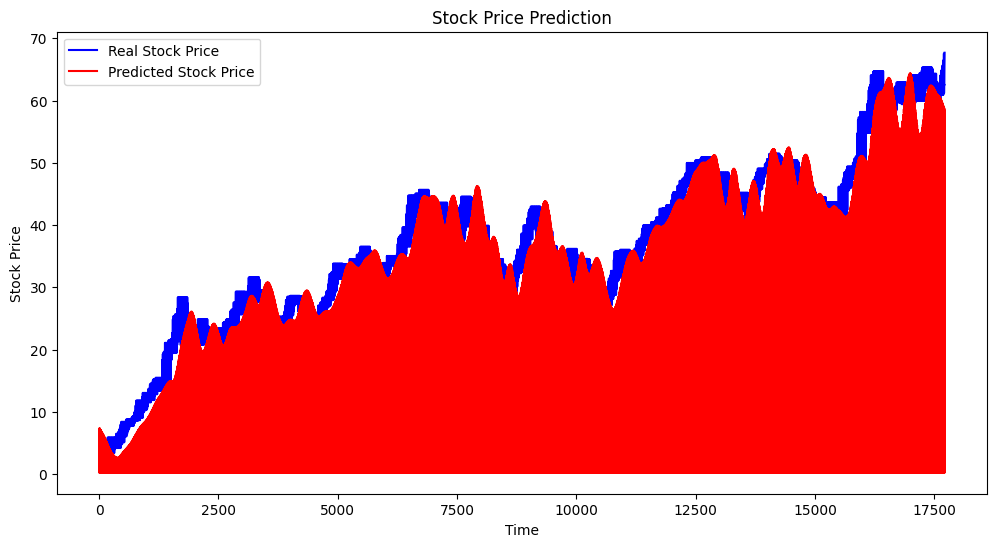

In [22]:
# Get data
data = get_stock_data(ticker, start_date, end_date)
data_values = data.values

# Train-Test Split
train_size = int(len(data_values) * 0.8)
train_data, test_data = data_values[:train_size], data_values[train_size:]

# Preprocess data
X_train, y_train, scaler = preprocess_data(train_data, look_back, output_steps)
X_test, y_test, _ = preprocess_data(test_data, look_back, output_steps)

# Reshape data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print("Shape of X_train:", X_train.shape)  # Should be (samples, look_back, 1)
print("Shape of y_train:", y_train.shape)  # Should be (samples, output_steps)

# Build the model
model = build_lstm_model(look_back, output_steps)

# Train the model
train_model(model, X_train, y_train, epochs=15, batch_size=32)

# Make predictions
predicted_stock_price = make_predictions(model, X_test, scaler)

# Inverse scale the actual prices for comparison
y_test_actual = scaler.inverse_transform(y_test)

# Visualize predictions
plot_predictions(y_test_actual, predicted_stock_price, "Stock Price Prediction")